Met/APP Data Cube \n /
# Multitemporal Analysis of Seasonal Burns in Burkina Faso
by Jyoti Biswas, Magdalena Fischer, Lallu Praphatan and Ina Schulz


# current situation of burns in Burkina Faso

# what is burning and why

In [1]:
# Import all needed packages
import datacube
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray as rio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
import geopandas as gpd
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard#, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices

In the following two cells, an application is created on the dataube called Brunt Area Mapping. \n
Afterwards, parameters for the dataset that will be loaded from the cube are defined.  \n
These can be adjusted to an area of interest including a certian area around a point of interest (buffer). \n
Next, the timeframe to be observed is entered. At this step, 

In [2]:
dc = datacube.Datacube(app="Burnt_area_mapping")

In [3]:
# Define the area of interest
lat = 11.69 #12.016
lon = -4.425 #-4.475
buffer = 0.1 # in decimal degreees

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Define timeframe, 4 fire seasons from october til may (data available from october 2013)
time = '2017-10-01', '2021-05-01'

# Choose the Landsat 8 products to load
products = ["ls8_sr"]

# Define resolution
resolution = (-30, 30)

# Define needed bands
measurements = ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'pixel_quality', 'radiometric_saturation']

# Define cloud mask threshold
min_gooddata = 0.6

In [4]:
# Create a reusable query with all needed parameters
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": resolution,
    "measurements": measurements, 
    "output_crs" : "EPSG:6933",
    "products": products,
    "min_gooddata": min_gooddata,
    "time":time
}

In [5]:
# Load all data based on set parameters avalible from ARD data
baseline_ard = load_ard(dc=dc,
                        group_by='solar_day',
                        **query)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr


/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class CommonTimestamp will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)
/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  

Counting good quality pixels for each time step
Filtering to 52 out of 77 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 52 time steps


## Normalized Burn Ratio

The Normalized Burn Ratio (**NBR**) is an index for identifing burnt areas. It uses the differences in the refelctance between green, healthy vegetation and burnt vegetation. For calculating the NBR the Near Infrared Band aswell as the Shortwave Infrared Band is needed. The NBR values range from -1 to 1, whereby negative values represent burnt vegetation or bare soil and positive values indicate healthy vegetation.
The NBR is calulated as followed:
     
                                                                    NBR = (NIR - SWIR)/(NIR+SWIR)

## Delta Normalized Burn Ratio

By calculating the difference between the NBR from before the fire season and the NBR after the fire seasons the changes can be detected. Since the delta Normalized Burn Ratio (**dNBR**) values represent the change in the area, it can be more usefule in terms of detecting areas where a burning event has happened.


                                                                   dNBR = NBR(pre) - NBR(post)
                                                                  
The positive values of the dNBR generally represent burnt areas, whereas negative values indicate unburnt areas. Furthermore, based on the values assumtions about the severity can be drawn:


> $\lt$ -0.25 => *High post-fire regrowth*\
-0.25 to -0.1 => *Low post-fire regrowth*\
-0.1 to 0.1 => *Unburned*\
0.1 to 0.27 => *Low-severity burn*\
0.27 to 0.44 => *Moderate-low severity burn*\
0.44 to 0.66 => *Moderate-high severity burn*\
$\gt$ 0.66 => *High-severity burn*

In [6]:
# Calculate NBR for the whole loaded datacube
baseline_ard = calculate_indices(baseline_ard,
                                 index='NBR',
                                 collection='c2',
                                 drop=False)

In [7]:
# Reprojct datacube to WGS84
dc_reproject = baseline_ard.rio.reproject("EPSG:4326")

In [8]:
# Create list including all loaded years
list_years = np.unique(dc_reproject.time.dt.year.values)
list_years

array([2017, 2018, 2019, 2020, 2021])

### RGB Plot of the Area  as well as NBR Median Pre, During, Post Fire Plots

Visiualizing the NBR values for the different timesteps during one burning season shows already some changes in the refelctance. Based on the fireevents registered on FIRMS, the October was choosen for the pre-fire-season. Therefore, the fire-season was defined to be from December til the end of march and the month April represents the post-fire-season. Due to many clouds during  May til September those month are not included in the comparisons. Further the median along the time axis is used to achieve the best possible result.\
In the following plots it is well visible that in October the NBR reflectance is mostly above 0 and indicates healthy, green vegetation. On the other hand the NBR reflectens values of the fire-season and the post-fire-season show less high values including negative ones which are indicators for burnt and less healthy vegetation. 

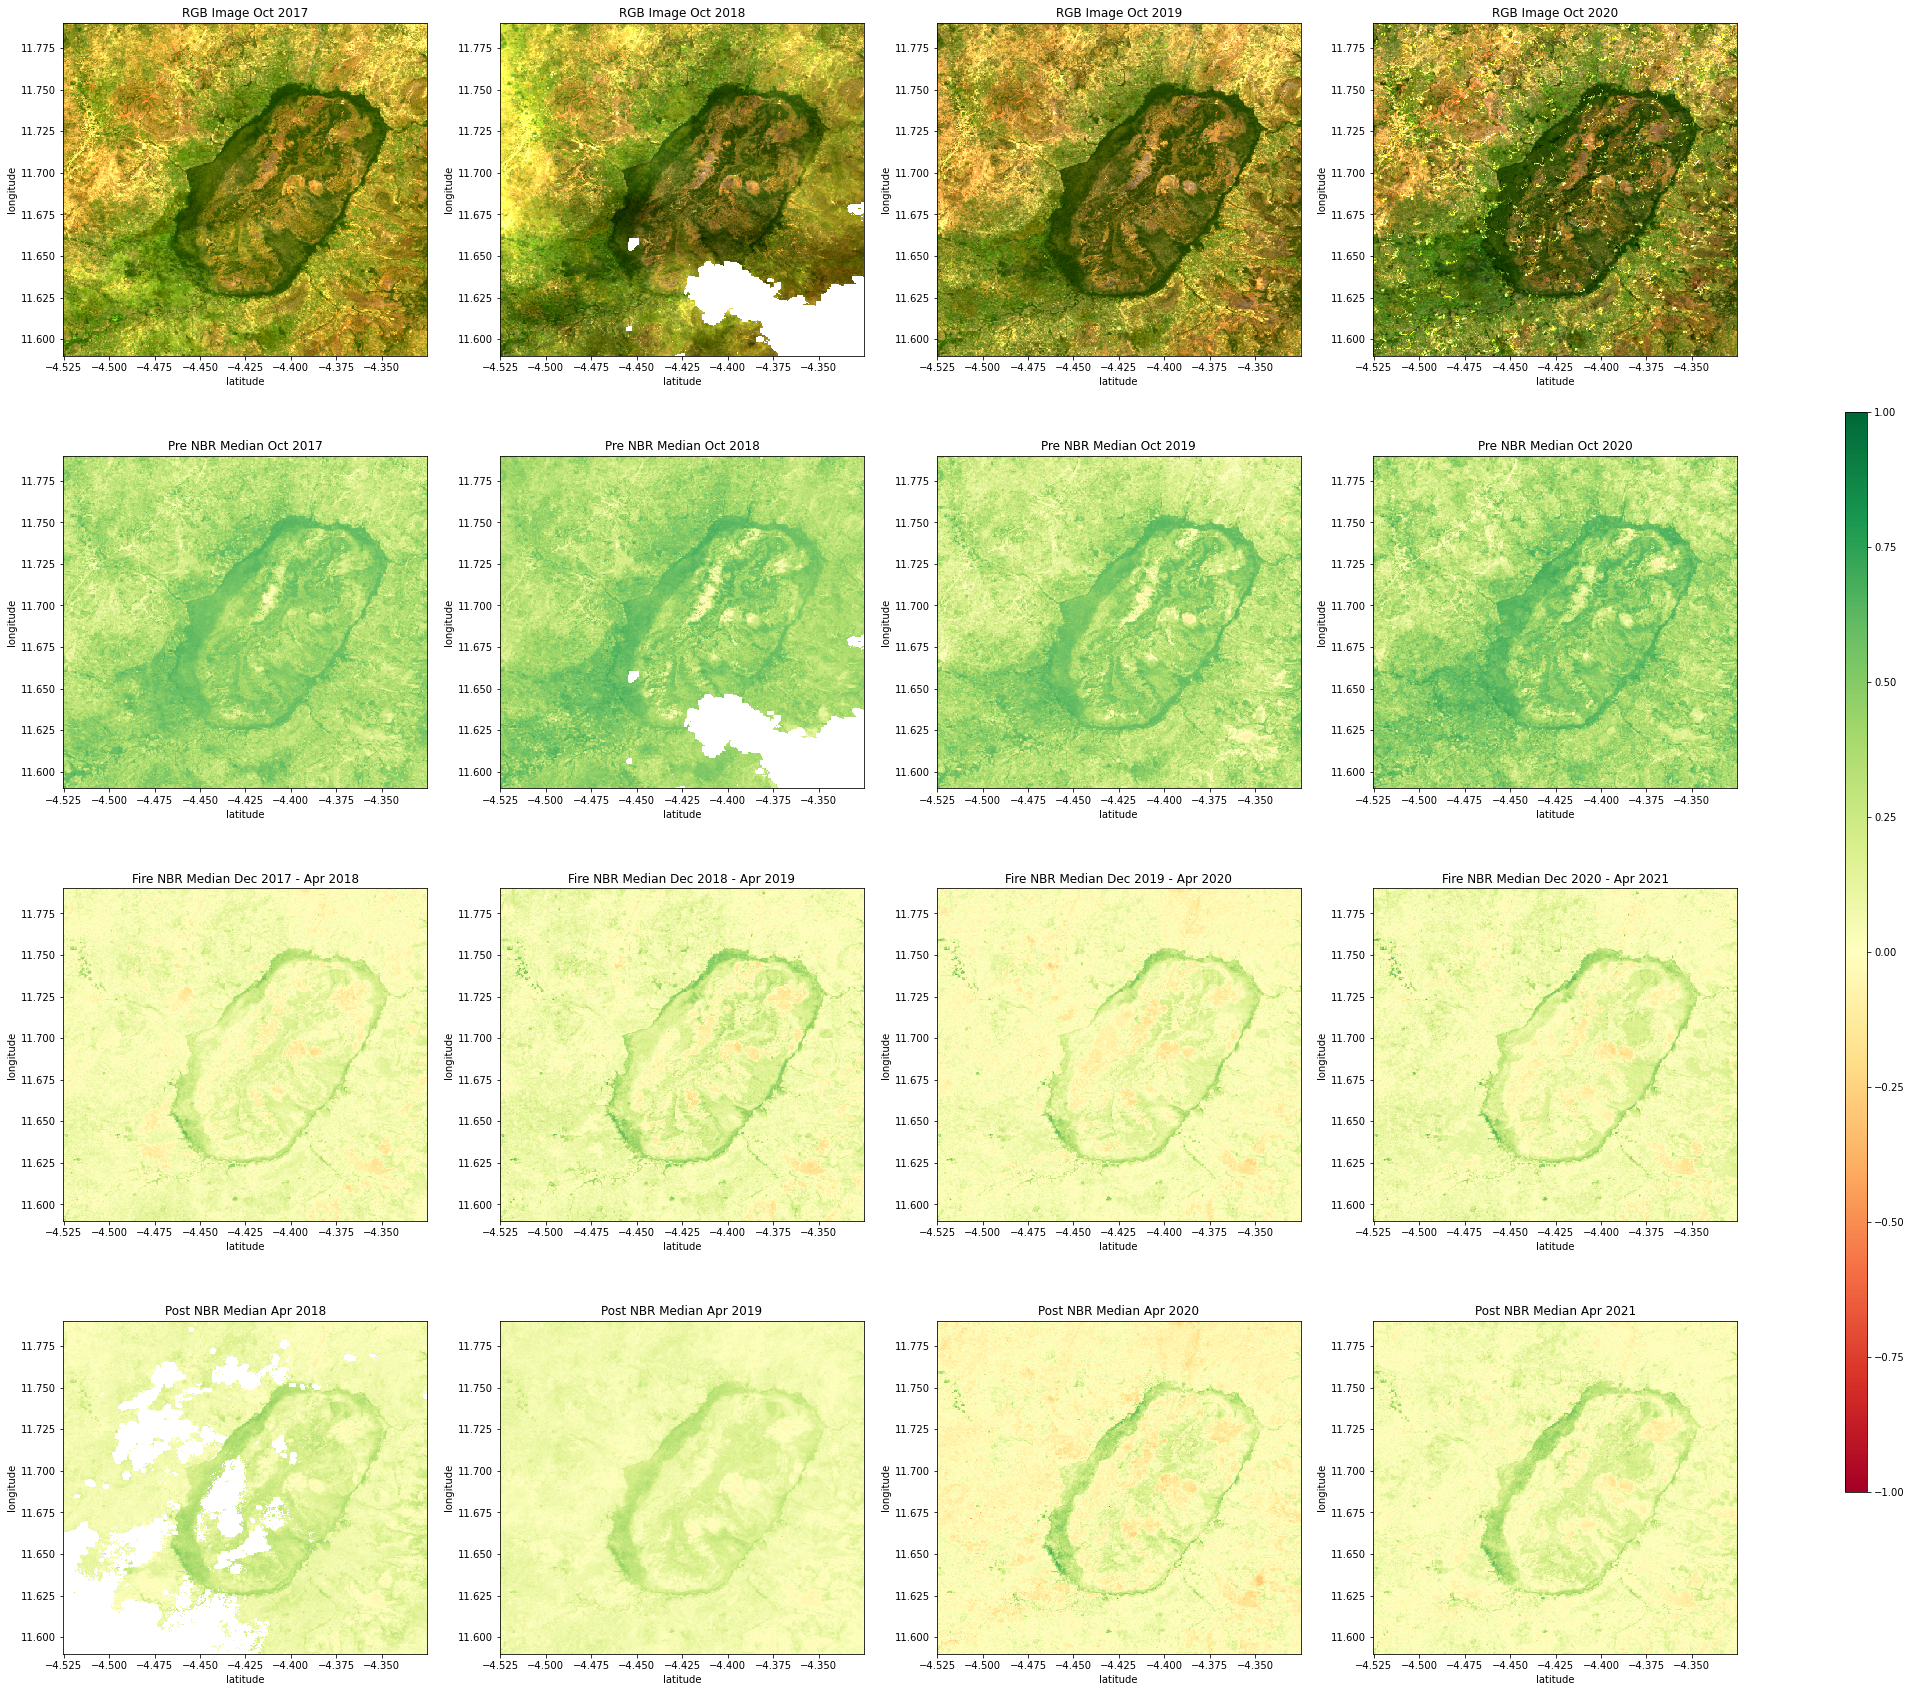

In [9]:
# Create plot frame with subplots for the four loaded seasons
f, axarr = plt.subplots(4, 4, figsize=(30, 30))

# Interate over the years creating pre, during and post fire subsets
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median 
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    fire_image = dc_reproject.sel(time=slice(str(pre_year) + '-12-01', str(post_year) + '-03-31')).median(dim='time')
    
    # Select NBR band
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
    fire_NBR_img = fire_image.NBR
    
    # Plotting RGB images
    rgb(pre_image, bands=['red', 'green', 'blue'], add_colorbar=False, ax=axarr[0, i])
    axarr[0, i].set_title('RGB Image Oct ' + str(list_years[i]))
    axarr[0, i].set_ylabel('longitude')
    axarr[0, i].set_xlabel('latitude')
    axarr[0, i].xaxis.set_visible(True)
    axarr[0, i].yaxis.set_visible(True)
    
    # Plotting pre fire NBR 
    pre_NBR_img.plot(cmap='RdYlGn', vmin=-1, vmax=1,
                  add_colorbar=False, ax=axarr[1, i])
    axarr[1, i].set_title('Pre NBR Median Oct ' + str(list_years[i]))
    axarr[1, i].set_ylabel('longitude')
    axarr[1, i].set_xlabel('latitude')
    axarr[1, i].xaxis.set_visible(True)
    axarr[1, i].yaxis.set_visible(True)
    
    # Plotting during fire season NBR
    fire_NBR_img.plot(cmap='RdYlGn', vmin=-1, vmax=1,
                  add_colorbar=False, ax=axarr[2, i])
    axarr[2, i].set_title('Fire NBR Median Dec ' + str(list_years[i])+' - Apr ' +str(list_years[i+1]))
    axarr[2, i].set_ylabel('longitude')
    axarr[2, i].set_xlabel('latitude')
    axarr[2, i].xaxis.set_visible(True)
    axarr[2, i].yaxis.set_visible(True)
    
    # Plotting post fire NBR
    im = post_NBR_img.plot(cmap='RdYlGn', vmin=-1, vmax=1,
                  add_colorbar=False, ax=axarr[3, i])
    axarr[3, i].set_title('Post NBR Median Apr ' + str(list_years[i+1]))
    axarr[3, i].set_ylabel('longitude')
    axarr[3, i].set_xlabel('latitude')
    axarr[3, i].xaxis.set_visible(True)
    axarr[3, i].yaxis.set_visible(True)
    
# Add one colorbar to all subplots, adjust spacing
cbar_ax1 = f.add_axes([0.95, 0.2, 0.01, 0.5])
f.colorbar(im, cax=cbar_ax1)
plt.subplots_adjust(hspace=0.3, wspace=0.2) 

### Delta NBR and Burnt Area Plots

Using the dNBR as indicator for change the visualisations below indicates burnt areas with positive values whereas unburnt areas are represented with negative values. Thereby, a threshold of 0.44 was used to differentiate between burnt areas and bare soil as well as getting an idea of where the severity of the fires was moderate or more. It is to be considered that clouds influence the results of the dNBR and of the burnt area. Since the unburnt vegetation also appears less green in the post-fire season due to changed conditions, the dNBR values are mostly greater than 0 and therefore the colorbar ranges from 0 to 1 to increase the contrast. 

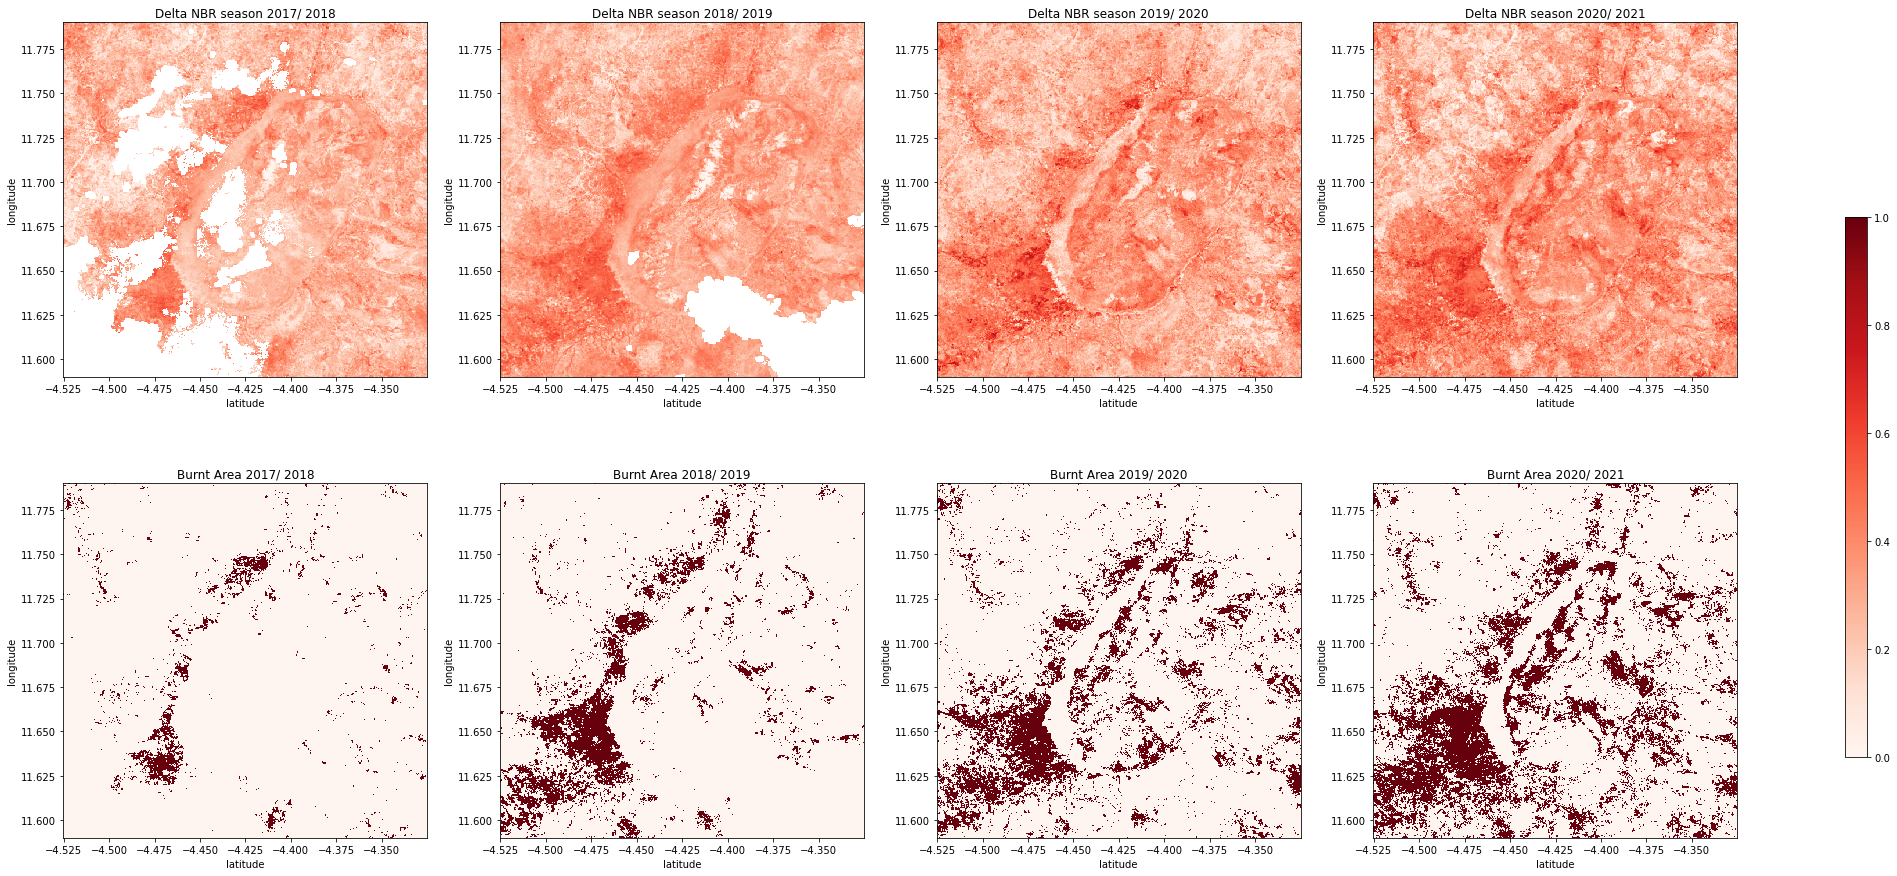

In [18]:
# Create plot frame with subplots for the four loaded seasons
f, axarr = plt.subplots(2, 4, figsize=(30, 15))

# Interate over the years creating delta NBR and burnt area subsets
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    
    # Select NBR band
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
        
    # Calculate delta NBR
    delta_NBR = pre_NBR_img - post_NBR_img
    # Set threshold
    threshold = 0.44 #moderate-high severity burn
    # Apply threshold
    burnt = delta_NBR > threshold
    
    # Plot delta NBR
    im = delta_NBR.plot(cmap='Reds', vmin=0, vmax=1,
                  add_colorbar=False, ax=axarr[0, i])
    axarr[0, i].set_title('Delta NBR season ' + str(list_years[i])+'/ '+ str(list_years[i+1]))
    axarr[0, i].set_ylabel('longitude')
    axarr[0, i].set_xlabel('latitude')
    axarr[0, i].xaxis.set_visible(True)
    axarr[0, i].yaxis.set_visible(True)
    
    # Plot burnt area 
    burnt.plot(cmap='Reds', add_colorbar=False, ax=axarr[1, i])
    axarr[1, i].set_title('Burnt Area ' + str(list_years[i])+'/ '+ str(list_years[i+1]))
    axarr[1, i].set_ylabel('longitude')
    axarr[1, i].set_xlabel('latitude')
    axarr[1, i].xaxis.set_visible(True)
    axarr[1, i].yaxis.set_visible(True)   
    
# Create one colorbar for all subplots and adjust spaceing
cbar_ax1 = f.add_axes([0.95, 0.2, 0.01, 0.5])
f.colorbar(im, cax=cbar_ax1)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

### Calculating Areas

In [15]:
# Iterating over all loaded years for calculating different areas
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    
    # Select NBR bands
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
    
    # Calculate delta NBR
    delta_NBR = pre_NBR_img - post_NBR_img
    # Set threshold
    threshold = 0.44 #moderate-high severity burn
    # Apply threshold
    burnt = delta_NBR > threshold

    # Constants for calculating burnt area
    pixel_length = resolution[1]  # in metres
    m_per_km = 1000  # conversion from metres to kilometres

    # Area per pixel
    area_per_pixel = pixel_length ** 2 / m_per_km ** 2

    # Calculate areas
    unburnt_area = (delta_NBR <= threshold).sum() * area_per_pixel
    burnt_area = burnt.sum() * area_per_pixel
    not_nan_area = delta_NBR.notnull().sum() * area_per_pixel
    nan_area = delta_NBR.isnull().sum() * area_per_pixel
    total_area = unburnt_area + burnt_area + nan_area
    print('\033[1m'+str(pre_year)+'/'+str(post_year)+'\033[0m')
    print(f'Unburnt area:                     {unburnt_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Burnt area:                       {burnt_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Nan area:                         {nan_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Total area (no nans):             {not_nan_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Total area (with nans):           {total_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Percentage of total area burnt:   {100*burnt_area.item()/total_area.item():.2f}%')
    print()
    print()

2017/2018
Unburnt area:                     377.30 km²
Burnt area:                       16.26 km²
Nan area:                         105.96 km²
Total area (no nans):             393.56 km²
Total area (with nans):           499.52 km²
Percentage of total area burnt:   3.26%


2018/2019
Unburnt area:                     407.70 km²
Burnt area:                       48.49 km²
Nan area:                         43.33 km²
Total area (no nans):             456.19 km²
Total area (with nans):           499.52 km²
Percentage of total area burnt:   9.71%


2019/2020
Unburnt area:                     424.13 km²
Burnt area:                       75.39 km²
Nan area:                         0.00 km²
Total area (no nans):             499.52 km²
Total area (with nans):           499.52 km²
Percentage of total area burnt:   15.09%


2020/2021
Unburnt area:                     395.01 km²
Burnt area:                       104.52 km²
Nan area:                         0.00 km²
Total area (no nans):          

### Frequency of Burning events, Plot

To get an idea of which areas burn more frequently than others, the following plot shows the added up burning events for the area of interest. Only pixels with an dNBR of greater than 0.44 are considered. The plot below shows that in the south west of the forest the most buring events between end of 2017 til 2021 happened. 

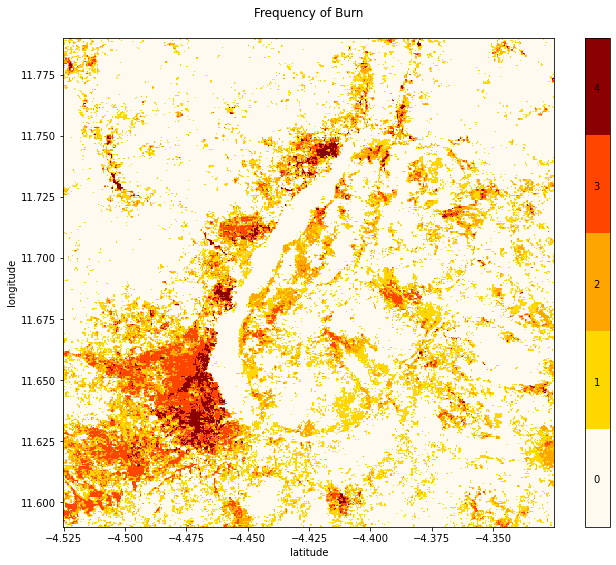

In [16]:
# Iterating over all loaded years for calculating frequency of burning
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    
    # Selecting NBR bands
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
    
    # Calculating delta NBR
    delta_NBR = pre_NBR_img - post_NBR_img
    # Set threshold
    threshold = 0.44 #moderate-high severity burn
    # Apply threshold
    burnt = delta_NBR > threshold
    # Converting True/False image into int image[1,0]
    burnt=burnt*1
    
    # first run initiating frequency map
    if i==0:
        frequency = burnt
        
    #adding up values to frequency
    else:
        frequency+=burnt

# Creating own colorramp and adding it to plot
cmap = ListedColormap(['floralwhite', 'gold', 'orange', 'orangered', 'darkred'])

# Create Plot for Frequency of 
fig = frequency.plot(cmap=cmap, figsize=(11, 9), add_colorbar=False)

# Set colorbar options
cbar=plt.colorbar(fig)
cbar.set_ticks(list())
for index, label in  enumerate(["0", "1", "2", "3", "4"]):
    x = 0.35
    y = ((2 * index+0.9 ) / 2.5)
    cbar.ax.text(x, y, label)

plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Frequency of Burn\n')

plt.show()

### Conclusion
The normalized burn ratio as well as the delta ormalized burn ratio can be used to detect areas where the a burning event might have happend. THereby the dNBR analyses the change over the burning season even more precious and combined with a threshold the actual area which burnt can be filtered. For some years the acutal burnt area might be lager than calculated, since some areas in the scene are covered by clouds. The closer look at the frequency of the burning events also revealed that most areas never burn or only one fire event happend on them, except for one larger region south of the Tere Forest. In this area a mixture of agricultural fields next to some small forest areas can be found.
The landsat-8 data used in this project is well suited for the purpose since the spatial resolution seems to be enough and the revisit time of 16 days provided at least one image per predefined season. 

For analysing wether a actual burning event happend in the areas where the dNBR was greater than 0.44 a dataset of tracked fires was used to identify the past fires in the region. The comparision between the NBR and the actual mapped fires can be found in the **script**